# Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

<center>
<img 
     src="http://www2.famaf.unc.edu.ar/~efernandez/egeo/img/logos/famaf.jpg" 
     alt="Drawing" 
     style="width:30%;"
/>
</center>

# Universidad Nacional de Córdoba
---

### Importación de librerías

In [72]:
import warnings
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

from pandas.plotting import lag_plot

import pyarrow
import fastparquet

import statsmodels

### Lectura del dataset 

In [73]:
df = pd.read_parquet('df_preprocesado.parquet')
df

,dni_titular_movimiento,anio_mes_cupon,antig_cliente,monto_ajustado,comercio_cat=0,comercio_cat=1,comercio_cat=2,comercio_cat=3,comercio_cat=4,comercio_cat=5,...,producto_naranja_movimiento=PL,producto_naranja_movimiento=PN,producto_naranja_movimiento=PP,producto_naranja_movimiento=TA,producto_naranja_movimiento=VI,producto_naranja_movimiento=ZE,tipo_producto_tarjeta_movimiento=0,tipo_producto_tarjeta_movimiento=3,tipo_producto_tarjeta_movimiento=4,fg_aumentado
0,000000b5aea2c9ea7cc155f6ebcef97f826,202008,225,-325.68,69.0,0.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0
1,000000b5aea2c9ea7cc155f6ebcef97f826,202009,226,-318.09,69.0,0.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0
2,000000b5aea2c9ea7cc155f6ebcef97f826,202010,227,-307.74,69.0,0.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0
3,000000b5aea2c9ea7cc155f6ebcef97f826,202011,228,-299.46,69.0,0.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0
4,000000b5aea2c9ea7cc155f6ebcef97f826,202012,229,-290.49,69.0,0.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7509,000f0b73ebfa002a79a0642b82e87919904,202101,21,801535.05,207.0,69.0,69.0,0.0,0.0,69.0,...,345.0,0.0,0.0,0.0,0.0,69.0,138.0,276.0,0.0,1
7510,000f0b73ebfa002a79a0642b82e87919904,202102,22,867100.92,207.0,69.0,0.0,0.0,0.0,0.0,...,207.0,0.0,0.0,0.0,0.0,69.0,138.0,138.0,0.0,0
7511,000f0b73ebfa002a79a0642b82e87919904,202103,23,183752.52,138.0,207.0,0.0,0.0,0.0,0.0,...,345.0,0.0,0.0,0.0,0.0,0.0,138.0,207.0,0.0,0
7512,000f0b73ebfa002a79a0642b82e87919904,202104,24,323309.16,276.0,0.0,138.0,0.0,0.0,0.0,...,345.0,0.0,0.0,0.0,0.0,69.0,138.0,276.0,0.0,1


Ordenamos nuestro conjunto de datos en función a la variable anio_mes_cupon.

In [74]:
df = df.sort_values(by = ['anio_mes_cupon'], ascending = True)
df

,dni_titular_movimiento,anio_mes_cupon,antig_cliente,monto_ajustado,comercio_cat=0,comercio_cat=1,comercio_cat=2,comercio_cat=3,comercio_cat=4,comercio_cat=5,...,producto_naranja_movimiento=PL,producto_naranja_movimiento=PN,producto_naranja_movimiento=PP,producto_naranja_movimiento=TA,producto_naranja_movimiento=VI,producto_naranja_movimiento=ZE,tipo_producto_tarjeta_movimiento=0,tipo_producto_tarjeta_movimiento=3,tipo_producto_tarjeta_movimiento=4,fg_aumentado
3566,00076679b5bc151d1212a68c2f78914a183,202007,101,111874.53,0.0,138.0,0.0,0.0,0.0,0.0,...,138.0,0.0,0.0,0.0,0.0,0.0,138.0,0.0,0.0,0
3888,000802084db4c5a6c311af12946aeefb662,202007,65,279687.36,0.0,69.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0
3898,000802e16e0ea151e8c748d14042412c907,202007,241,427159.68,69.0,138.0,0.0,0.0,0.0,0.0,...,207.0,0.0,0.0,0.0,69.0,0.0,69.0,69.0,69.0,0
3908,00080398be0d432718287f5ce174331e089,202007,225,53978.70,0.0,0.0,0.0,0.0,0.0,69.0,...,69.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0
526,0000e51596241209d79e11facdef204f268,202007,34,514844.19,0.0,0.0,69.0,0.0,0.0,69.0,...,138.0,0.0,0.0,0.0,0.0,0.0,0.0,138.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4802,0009d755757673758d8a50f3e0a7d346850,202105,187,19740.90,69.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,69.0,0.0,69.0,0.0,0
4843,000a0afc48e19badad3197ab43801c2d312,202105,158,858273.06,69.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,69.0,0.0,69.0,0.0,0
4861,000a18788f7ad80a5a5f28a9afb8e2e8329,202105,38,-9568.23,69.0,0.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0
7513,000f0b73ebfa002a79a0642b82e87919904,202105,25,142402.89,69.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,69.0,0.0,69.0,0.0,0


In [75]:
df['monto_ajustado'].describe().round(2)

count       7514.00
mean      807589.43
std      1025642.13
min      -977066.91
25%        65113.61
50%       427092.40
75%      1177538.20
max      9249133.98
Name: monto_ajustado, dtype: float64

Distribución de nuestro target respecto a nuestros features

### ScatterPlot de Features y Target

In [76]:
df_sin_docu = df.copy()
df_sin_docu.drop(columns=['dni_titular_movimiento','monto_ajustado'], inplace=True)
df_sin_docu['monto_ajustado'] = df['monto_ajustado']

In [77]:
col_x = df_sin_docu.iloc[:,:-1].columns.values
col_x

array(['anio_mes_cupon', 'antig_cliente', 'comercio_cat=0',
       'comercio_cat=1', 'comercio_cat=2', 'comercio_cat=3',
       'comercio_cat=4', 'comercio_cat=5', 'comercio_cat=6',
       'comercio_cat=7', 'comercio_cat=8', 'comercio_cat=9',
       'producto_naranja_movimiento=AX', 'producto_naranja_movimiento=EX',
       'producto_naranja_movimiento=MC', 'producto_naranja_movimiento=PC',
       'producto_naranja_movimiento=PL', 'producto_naranja_movimiento=PN',
       'producto_naranja_movimiento=PP', 'producto_naranja_movimiento=TA',
       'producto_naranja_movimiento=VI', 'producto_naranja_movimiento=ZE',
       'tipo_producto_tarjeta_movimiento=0',
       'tipo_producto_tarjeta_movimiento=3',
       'tipo_producto_tarjeta_movimiento=4', 'fg_aumentado'], dtype=object)

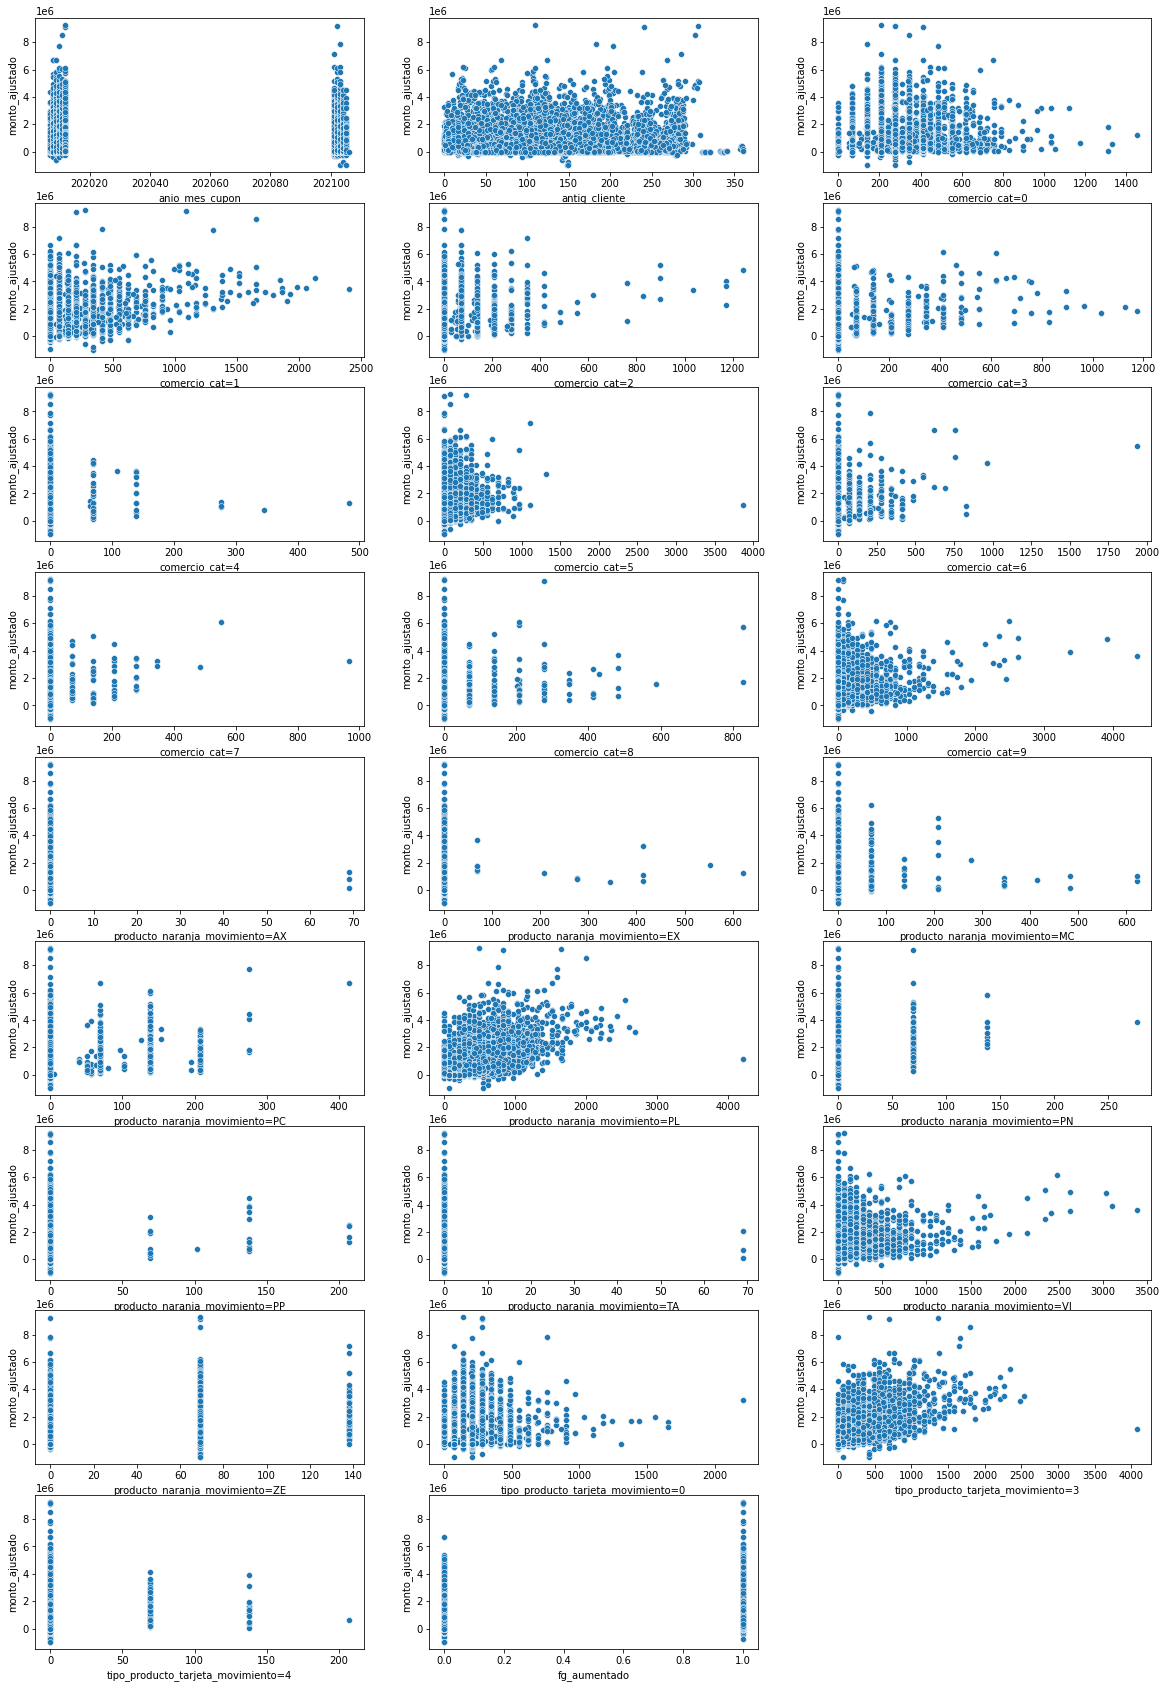

In [78]:
n_cols = 3
n_rows = math.ceil(len(col_x)/3)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 30))
count = 0
for i in col_x:    
    # Calculamos filas y columnas
    row = math.floor(count / n_cols)
    col = count % n_cols
    # Configuramos visualización
    ax = axs[row, col]
    # Visualizamos la distribución de variable
    sns.scatterplot(data=df_sin_docu, x=i, y='monto_ajustado', ax=ax)
    count =count +1

axs[n_rows-1,n_cols-1].axis('off')
plt.show()

### División para regresión y clasificación

En primer lugar, separamos nuestros feautures de los variables target para regresión y clasificación. La división entre train y validation se realizará previo a instanciar cada modelo, debido a que cada uno de ellos requiere un escalado distinto (por ejemplo, un escalado del tipo MaxAbsScaler, utiliza el máximo de todos los features para realizar el preprocesamiento). 

In [79]:
X = df.drop(['dni_titular_movimiento'], axis=1)

X_r = X.drop(['monto_ajustado'], axis=1)
X_c = X.drop(['fg_aumentado', 'monto_ajustado'], axis=1)
y_r = X['monto_ajustado']
y_c = X['fg_aumentado']

## 3. Regresión

Una vez finalizada la etapa de preprocesamiento, se propone implementar diferentes modelos 
de predicción para el `monto_compra_movimiento`, utilizando la librería Scikit-Learn:

* LinearSVR ([Doc](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html#sklearn.svm.LinearSVR))
* SGDRegressor ([Doc](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor))
* KNeighborsRegressor ([Doc](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor))
* GaussianProcessRegressor ([Doc](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor))
* VotingRegressor ([Doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html#sklearn.ensemble.VotingRegressor))

Y de la libreria XGBoost
* XGBRegressor ([Doc](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor))

De estos tipos de modelos, cuál creen que es el más adecuado para nuestro caso de aplicación?

Utilizar el método Grid Search, o de búsqueda exahustiva, con cross-validation para profundizar en la búsqueda y selección de hiperparámetros.

Calcular métricas sobre el conjunto de entrenamiento y de evaluación para los mejores parámetros obtenidos:
* MSE 
* MAE 
* RMSE

Comparar las métricas obtenidas en cada modelo y obtener conclusiones.

> Una vez encontrado el mejor modelo se validara usando el conjunto de evaluacion dado por el mentor

### Linear SVR - Default

In [80]:
from sklearn.svm import LinearSVR

In [81]:
# división train y test
X_train_r, X_val_r, y_train_r, y_val_r = train_test_split(X_r, y_r, test_size=0.3, random_state=0, shuffle=False)

In [82]:
# escalado de feauteres y target
x_scaler = MinMaxScaler() #MaxAbsScaler()
y_scaler = MinMaxScaler() #MaxAbsScaler()
X_train_r = x_scaler.fit_transform(X_train_r)
X_val_r = x_scaler.transform(X_val_r)
y_train_r = y_scaler.fit_transform(y_train_r.values.reshape(-1, 1))
y_val_r = y_scaler.transform(y_val_r.values.reshape(-1, 1))

In [83]:
#standar= StandardScaler()
#standar.fit_transform(X_r[['anio_mes_cupon']].values.reshape(-1, 1))

In [84]:
X_r.head(10)

,anio_mes_cupon,antig_cliente,comercio_cat=0,comercio_cat=1,comercio_cat=2,comercio_cat=3,comercio_cat=4,comercio_cat=5,comercio_cat=6,comercio_cat=7,...,producto_naranja_movimiento=PL,producto_naranja_movimiento=PN,producto_naranja_movimiento=PP,producto_naranja_movimiento=TA,producto_naranja_movimiento=VI,producto_naranja_movimiento=ZE,tipo_producto_tarjeta_movimiento=0,tipo_producto_tarjeta_movimiento=3,tipo_producto_tarjeta_movimiento=4,fg_aumentado
3566,202007,101,0.0,138.0,0.0,0.0,0.0,0.0,0.0,0.0,...,138.0,0.0,0.0,0.0,0.0,0.0,138.0,0.0,0.0,0
3888,202007,65,0.0,69.0,0.0,0.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0
3898,202007,241,69.0,138.0,0.0,0.0,0.0,0.0,0.0,0.0,...,207.0,0.0,0.0,0.0,69.0,0.0,69.0,69.0,69.0,0
3908,202007,225,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0
526,202007,34,0.0,0.0,69.0,0.0,0.0,69.0,0.0,0.0,...,138.0,0.0,0.0,0.0,0.0,0.0,0.0,138.0,0.0,0
3933,202007,53,0.0,207.0,0.0,69.0,0.0,0.0,0.0,0.0,...,276.0,0.0,0.0,0.0,0.0,0.0,0.0,276.0,0.0,0
3944,202007,35,69.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,69.0,0.0,0.0,0.0,69.0,0.0,0.0,0
3955,202007,34,69.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,...,69.0,0.0,0.0,0.0,138.0,69.0,0.0,138.0,0.0,0
3966,202007,18,69.0,69.0,0.0,0.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,69.0,0.0,138.0,0.0,0
515,202007,280,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0


In [85]:
pd.DataFrame(X_train_r, columns=X_r.columns.values).head(10)

,anio_mes_cupon,antig_cliente,comercio_cat=0,comercio_cat=1,comercio_cat=2,comercio_cat=3,comercio_cat=4,comercio_cat=5,comercio_cat=6,comercio_cat=7,...,producto_naranja_movimiento=PL,producto_naranja_movimiento=PN,producto_naranja_movimiento=PP,producto_naranja_movimiento=TA,producto_naranja_movimiento=VI,producto_naranja_movimiento=ZE,tipo_producto_tarjeta_movimiento=0,tipo_producto_tarjeta_movimiento=3,tipo_producto_tarjeta_movimiento=4,fg_aumentado
0,0.0,0.280556,0.000000,0.057452,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.032787,0.0,0.000000,0.0,0.000000,0.0,0.083333,0.000000,0.000000,0.0
1,0.0,0.180556,0.000000,0.028726,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.016393,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.016949,0.000000,0.0
2,0.0,0.669444,0.047619,0.057452,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.049180,0.0,0.000000,0.0,0.020408,0.0,0.041667,0.016949,0.333333,0.0
3,0.0,0.625000,0.000000,0.000000,0.000000,0.000000,0.0,0.017857,0.0,0.0,...,0.016393,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.016949,0.000000,0.0
4,0.0,0.094444,0.000000,0.000000,0.055556,0.000000,0.0,0.017857,0.0,0.0,...,0.032787,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.033898,0.000000,0.0
5,0.0,0.147222,0.000000,0.086178,0.000000,0.066667,0.0,0.000000,0.0,0.0,...,0.065574,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.067797,0.000000,0.0
6,0.0,0.097222,0.047619,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.333333,0.0,0.000000,0.0,0.041667,0.000000,0.000000,0.0
7,0.0,0.094444,0.047619,0.000000,0.000000,0.000000,0.0,0.017857,0.0,0.0,...,0.016393,0.0,0.000000,0.0,0.040816,0.5,0.000000,0.033898,0.000000,0.0
8,0.0,0.050000,0.047619,0.028726,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.016393,0.0,0.000000,0.0,0.000000,0.5,0.000000,0.033898,0.000000,0.0
9,0.0,0.777778,0.000000,0.000000,0.000000,0.000000,0.0,0.017857,0.0,0.0,...,0.016393,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.016949,0.000000,0.0


In [86]:
pd.DataFrame(X_val_r, columns=X_r.columns.values).head(10)

,anio_mes_cupon,antig_cliente,comercio_cat=0,comercio_cat=1,comercio_cat=2,comercio_cat=3,comercio_cat=4,comercio_cat=5,comercio_cat=6,comercio_cat=7,...,producto_naranja_movimiento=PL,producto_naranja_movimiento=PN,producto_naranja_movimiento=PP,producto_naranja_movimiento=TA,producto_naranja_movimiento=VI,producto_naranja_movimiento=ZE,tipo_producto_tarjeta_movimiento=0,tipo_producto_tarjeta_movimiento=3,tipo_producto_tarjeta_movimiento=4,fg_aumentado
0,1.0,0.400000,0.095238,0.057452,0.0,0.066667,0.0,0.000000,0.0,0.0,...,0.065574,0.0,0.0,0.0,0.000000,0.5,0.041667,0.067797,0.0,0.0
1,1.0,0.647222,0.142857,0.028726,0.0,0.000000,0.0,0.017857,0.0,0.0,...,0.114754,0.0,0.0,0.0,0.040816,0.5,0.083333,0.101695,0.0,0.0
2,1.0,0.761111,0.142857,0.069109,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.072226,0.0,0.0,0.0,0.000000,0.5,0.083333,0.057725,0.0,1.0
3,1.0,0.188889,0.142857,0.373439,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.245902,0.0,0.0,0.0,0.244898,0.5,0.083333,0.237288,0.0,0.0
4,1.0,0.069444,0.333333,0.057452,0.0,0.000000,0.0,0.017857,0.0,0.0,...,0.131148,0.0,0.0,0.0,0.000000,0.0,0.208333,0.084746,0.0,1.0
5,1.0,0.300000,0.238095,0.086178,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.114754,0.0,0.0,0.0,0.000000,0.5,0.333333,0.000000,0.0,1.0
6,1.0,0.183333,0.165631,0.028726,0.0,0.000000,0.0,0.017857,0.0,0.0,...,0.089808,0.0,0.0,0.0,0.265306,0.0,0.083333,0.033898,0.0,0.0
7,1.0,0.494444,0.346446,0.028726,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.135662,0.0,0.0,0.0,0.081633,0.0,0.166667,0.016949,0.0,0.0
8,1.0,0.422222,0.095238,0.000000,0.0,0.000000,0.0,0.017857,0.0,0.0,...,0.049180,0.0,0.0,0.0,0.000000,0.0,0.083333,0.016949,0.0,0.0
9,1.0,0.944444,0.190476,0.028726,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.081967,0.0,0.0,0.0,0.000000,0.0,0.166667,0.016949,0.0,1.0


In [87]:
# fit
svr = LinearSVR(random_state=0)
svr.fit(X_train_r, y_train_r)

c:\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVR(random_state=0)

In [88]:
# Predict
y_train_pred_svr = svr.predict(X_train_r)
y_valid_pred_svr = svr.predict(X_val_r)

In [89]:
#y_scaler.inverse_transform(y_val_r)

In [90]:
# evaluate MSE:
train_error_svr = mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_svr.reshape(-1,1)))
val_error_svr = mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_svr.reshape(-1,1)))
print(f'Train error MSE {train_error_svr.round(3)}, Valid error MSE {val_error_svr.round(3)}') 

Train error MSE 555599833875.232, Valid error MSE 476884181765.861


In [91]:
# evaluate MAE:
train_error_svr = mean_absolute_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_svr.reshape(-1,1)))
val_error_svr = mean_absolute_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_svr.reshape(-1,1)))
print(f'Train error MAE {train_error_svr.round(3)}, Valid error MAE {val_error_svr.round(3)}') 

Train error MAE 411126.844, Valid error MAE 384999.174


In [92]:
# evaluate RMSE:
train_error_svr = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_svr.reshape(-1,1))))
val_error_svr = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_svr.reshape(-1,1))))
print(f'Train error RMSE {train_error_svr.round(3)}, Valid error RMSE {val_error_svr.round(3)}') 

Train error RMSE 745385.695, Valid error RMSE 690568.014


Visualizamos nuestra variable target (real y predicción)

In [93]:
pd.DataFrame(y_scaler.inverse_transform(y_val_r), columns=['val_real']).describe().round(2)

,val_real
count,2255.00
mean,755446.81
std,959321.45
min,-977066.91
25%,53494.32
50%,412395.06
75%,1090843.08
max,9171482.43


In [94]:
pd.DataFrame(y_scaler.inverse_transform(y_valid_pred_svr.reshape(-1,1)), columns=['val_pred']).describe().round(2)

,val_pred
count,2255.00
mean,615317.46
std,631905.96
min,-113396.35
25%,148686.27
50%,423904.56
75%,906514.35
max,7197800.12


### Linear SVR - Grid Search

In [95]:
param_grid = {
    'epsilon': [0.1, 0.01, 0.0001,0.001],
    'tol': [1e-3, 1e-4, 1e-5, 1e-6],
    'C': [1, 2, 0.01, 0.001],
    'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']
}

cv_svr = GridSearchCV(svr, param_grid, scoring='neg_mean_squared_error',cv=5)
cv_svr.fit(X_train_r, y_train_r)

c:\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\python39\lib\

GridSearchCV(cv=5, estimator=LinearSVR(random_state=0),
             param_grid={'C': [1, 2, 0.01, 0.001],
                         'epsilon': [0.1, 0.01, 0.0001, 0.001],
                         'loss': ['epsilon_insensitive',
                                  'squared_epsilon_insensitive'],
                         'tol': [0.001, 0.0001, 1e-05, 1e-06]},
             scoring='neg_mean_squared_error')

In [96]:
cv_svr.best_params_

{'C': 1,
 'epsilon': 0.0001,
 'loss': 'squared_epsilon_insensitive',
 'tol': 0.001}

In [97]:
cv_svr.best_estimator_

LinearSVR(C=1, epsilon=0.0001, loss='squared_epsilon_insensitive',
          random_state=0, tol=0.001)

In [98]:
# Predict
y_train_pred_svr = cv_svr.best_estimator_.predict(X_train_r)
y_valid_pred_svr = cv_svr.best_estimator_.predict(X_val_r)

In [99]:
# evaluate MSE:
train_error_svr = mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_svr.reshape(-1,1)))
val_error_svr = mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_svr.reshape(-1,1)))
print(f'Train error MSE {train_error_svr.round(3)}, Valid error MSE {val_error_svr.round(3)}') 

Train error MSE 514613507531.611, Valid error MSE 446276554686.966


In [100]:
# evaluate MAE:
train_error_svr = mean_absolute_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_svr.reshape(-1,1)))
val_error_svr = mean_absolute_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_svr.reshape(-1,1)))
print(f'Train error MAE {train_error_svr.round(3)}, Valid error MAE {val_error_svr.round(3)}') 

Train error MAE 443745.381, Valid error MAE 424034.806


In [101]:
# evaluate RMSE:
train_error_svr = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_svr.reshape(-1,1))))
val_error_svr = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_svr.reshape(-1,1))))
print(f'Train error RMSE {train_error_svr.round(3)}, Valid error RMSE {val_error_svr.round(3)}') 

Train error RMSE 717365.672, Valid error RMSE 668039.336


In [102]:
pd.DataFrame(y_scaler.inverse_transform(y_val_r), columns=['val_real']).describe().round(2)

,val_real
count,2255.00
mean,755446.81
std,959321.45
min,-977066.91
25%,53494.32
50%,412395.06
75%,1090843.08
max,9171482.43


In [103]:
pd.DataFrame(y_scaler.inverse_transform(y_valid_pred_svr.reshape(-1,1)), columns=['val_pred']).describe().round(2)

,val_pred
count,2255.00
mean,795833.69
std,695090.16
min,-128440.56
25%,215551.40
50%,633054.68
75%,1132360.46
max,6437653.89


### SGDRegressor - Default

In [104]:
from sklearn.linear_model import SGDRegressor

Utilizamos las variables X_train_r, X_val_r, y_train_r, y_val_r debido a que en este modelo utilizamos el mismo escalado que SVM-R. 

In [105]:
# Fit
sgd = SGDRegressor(random_state=0, shuffle=False)
sgd.fit(X_train_r, y_train_r)

c:\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SGDRegressor(random_state=0, shuffle=False)

In [106]:
# Predict
y_train_pred_sgd = sgd.predict(X_train_r)
y_valid_pred_sgd = sgd.predict(X_val_r)

In [107]:
# evaluate:
train_error_sgd = mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_sgd.reshape(-1,1)))
val_error_sgd = mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_sgd.reshape(-1,1)))
print(f'Train error {train_error_sgd.round(3)}, Valid error {val_error_sgd.round(3)}')  

Train error 665110104800.543, Valid error 579962354318.857


In [108]:
# evaluate MAE:
train_error_sgd = mean_absolute_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_sgd.reshape(-1,1)))
val_error_sgd = mean_absolute_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_sgd.reshape(-1,1)))
print(f'Train error MAE {train_error_sgd.round(3)}, Valid error MAE {val_error_sgd.round(3)}') 

Train error MAE 559746.058, Valid error MAE 526384.376


In [109]:
# evaluate RMSE:
train_error_sgd = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_sgd.reshape(-1,1))))
val_error_sgd = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_sgd.reshape(-1,1))))
print(f'Train error RMSE {train_error_sgd.round(3)}, Valid error RMSE {val_error_sgd.round(3)}') 

Train error RMSE 815542.828, Valid error RMSE 761552.595


Visualizamos nuestra variable target (real y predicción)

In [110]:
pd.DataFrame(y_scaler.inverse_transform(y_val_r), columns=['val_real']).describe().round(2)

,val_real
count,2255.00
mean,755446.81
std,959321.45
min,-977066.91
25%,53494.32
50%,412395.06
75%,1090843.08
max,9171482.43


In [111]:
pd.DataFrame(y_scaler.inverse_transform(y_valid_pred_sgd.reshape(-1,1)), columns=['val_pred']).describe().round(2)

,val_pred
count,2255.00
mean,815758.20
std,518220.96
min,114477.66
25%,333120.30
50%,798496.64
75%,1133045.62
max,3043526.09


### SGDRegressor- Grid Search

In [112]:
param_grid = {
    'loss': ['squared_loss','huber','epsilon_insensitive','squared_epsilon_insensitive'],
    'penalty': ['l2','l1'],
    'alpha': [0.001, 0.01, 0.1, 1],
    'epsilon': [0.1, 0.01],
    'tol': [1e-3, 1e-4],
    'learning_rate': ['optimal', 'constant', 'adaptive','invscaling']
    #'max_iter': [1000, 2000, 5000]
}

cv_sgd = GridSearchCV(sgd, param_grid, scoring='neg_mean_squared_error',cv=5)
cv_sgd.fit(X_train_r, y_train_r)

c:\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
c:\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of

GridSearchCV(cv=5, estimator=SGDRegressor(random_state=0, shuffle=False),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1], 'epsilon': [0.1, 0.01],
                         'learning_rate': ['optimal', 'constant', 'adaptive',
                                           'invscaling'],
                         'loss': ['squared_loss', 'huber',
                                  'epsilon_insensitive',
                                  'squared_epsilon_insensitive'],
                         'penalty': ['l2', 'l1'], 'tol': [0.001, 0.0001]},
             scoring='neg_mean_squared_error')

In [113]:
cv_sgd.best_params_

{'alpha': 0.001,
 'epsilon': 0.01,
 'learning_rate': 'adaptive',
 'loss': 'squared_epsilon_insensitive',
 'penalty': 'l2',
 'tol': 0.0001}

In [114]:
cv_sgd.best_estimator_

SGDRegressor(alpha=0.001, epsilon=0.01, learning_rate='adaptive',
             loss='squared_epsilon_insensitive', random_state=0, shuffle=False,
             tol=0.0001)

In [115]:
# Predict
y_train_pred_sgd = cv_sgd.best_estimator_.predict(X_train_r)
y_valid_pred_sgd = cv_sgd.best_estimator_.predict(X_val_r)

In [116]:
# evaluate MSE:
train_error_sgd = mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_sgd.reshape(-1,1)))
val_error_sgd = mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_sgd.reshape(-1,1)))
print(f'Train error {train_error_sgd.round(3)}, Valid error {val_error_sgd.round(3)}')   

Train error 528322390418.634, Valid error 453069493341.998


In [117]:
# evaluate MAE:
train_error_sgd = mean_absolute_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_sgd.reshape(-1,1)))
val_error_sgd = mean_absolute_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_sgd.reshape(-1,1)))
print(f'Train error MAE {train_error_sgd.round(3)}, Valid error MAE {val_error_sgd.round(3)}') 

Train error MAE 470732.858, Valid error MAE 444634.687


In [118]:
# evaluate RMSE:
train_error_sgd = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_sgd.reshape(-1,1))))
val_error_sgd = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_sgd.reshape(-1,1))))
print(f'Train error RMSE {train_error_sgd.round(3)}, Valid error RMSE {val_error_sgd.round(3)}') 

Train error RMSE 726857.889, Valid error RMSE 673104.37


Visualizamos nuestra variable target (real y predicción)

In [119]:
pd.DataFrame(y_scaler.inverse_transform(y_val_r), columns=['val_real']).describe().round(2)

,val_real
count,2255.00
mean,755446.81
std,959321.45
min,-977066.91
25%,53494.32
50%,412395.06
75%,1090843.08
max,9171482.43


In [120]:
pd.DataFrame(y_scaler.inverse_transform(y_valid_pred_sgd.reshape(-1,1)), columns=['val_pred']).describe().round(2)

,val_pred
count,2255.00
mean,826514.06
std,653029.07
min,48919.68
25%,272683.75
50%,687122.25
75%,1174824.59
max,5655474.49


### KNeighborsRegressor - Default

In [121]:
from sklearn.neighbors import KNeighborsRegressor

In [122]:
neigh = KNeighborsRegressor()
neigh.fit(X_train_r, y_train_r)

KNeighborsRegressor()

In [123]:
# Predict
y_train_pred_neigh = neigh.predict(X_train_r)
y_valid_pred_neigh = neigh.predict(X_val_r)

In [124]:
# evaluate MSE:
train_error_neigh = mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_neigh.reshape(-1,1)))
val_error_neigh = mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_neigh.reshape(-1,1)))
print(f'Train error {train_error_neigh.round(3)}, Valid error {val_error_neigh.round(3)}')   

Train error 394928013033.009, Valid error 564129066858.451


In [125]:
# evaluate MAE:
train_error_neigh = mean_absolute_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_neigh.reshape(-1,1)))
val_error_neigh = mean_absolute_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_neigh.reshape(-1,1)))
print(f'Train error {train_error_neigh.round(3)}, Valid error {val_error_neigh.round(3)}')   

Train error 370738.468, Valid error 443178.22


In [126]:
# evaluate RMSE:
train_error_neigh = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_neigh.reshape(-1,1))))
val_error_neigh = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_neigh.reshape(-1,1))))
print(f'Train error {train_error_neigh.round(3)}, Valid error {val_error_neigh.round(3)}') 

Train error 628432.982, Valid error 751085.259


In [127]:
pd.DataFrame(y_scaler.inverse_transform(y_val_r), columns=['val_real']).describe().round(2)

,val_real
count,2255.00
mean,755446.81
std,959321.45
min,-977066.91
25%,53494.32
50%,412395.06
75%,1090843.08
max,9171482.43


In [128]:
pd.DataFrame(y_scaler.inverse_transform(y_valid_pred_neigh.reshape(-1,1)), columns=['val_pred']).describe().round(2)

,val_pred
count,2255.00
mean,666612.28
std,647021.04
min,-120189.31
25%,102053.55
50%,546077.04
75%,1012110.35
max,3791598.99


### KNeighborsRegressor - Grid Search

In [129]:
param_grid = {
    'n_neighbors': [2, 3, 4, 5],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto','ball_tree','kd_tree','brute'],
    'p': [1,2]
}

cv_neigh = GridSearchCV(neigh, param_grid, scoring='neg_mean_squared_error',cv=5)
cv_neigh.fit(X_train_r, y_train_r)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [2, 3, 4, 5], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

In [130]:
cv_neigh.best_params_

{'algorithm': 'kd_tree', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}

In [131]:
cv_neigh.best_estimator_

KNeighborsRegressor(algorithm='kd_tree', p=1, weights='distance')

In [132]:
# Predict
y_train_pred_neigh = cv_neigh.best_estimator_.predict(X_train_r)
y_valid_pred_neigh = cv_neigh.best_estimator_.predict(X_val_r)

In [133]:
# evaluate MSE:
train_error_neigh = mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_neigh.reshape(-1,1)))
val_error_neigh = mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_neigh.reshape(-1,1)))
print(f'Train error {train_error_neigh.round(3)}, Valid error {val_error_neigh.round(3)}')   

Train error 1182861833.433, Valid error 542780566668.357


In [134]:
# evaluate MAE:
train_error_neigh = mean_absolute_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_neigh.reshape(-1,1)))
val_error_neigh = mean_absolute_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_neigh.reshape(-1,1)))
print(f'Train error {train_error_neigh.round(3)}, Valid error {val_error_neigh.round(3)}')   

Train error 1705.695, Valid error 432815.199


In [135]:
# evaluate RMSE:
train_error_neigh = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_neigh.reshape(-1,1))))
val_error_neigh = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_neigh.reshape(-1,1))))
print(f'Train error {train_error_neigh.round(3)}, Valid error {val_error_neigh.round(3)}') 

Train error 34392.758, Valid error 736736.43


Visualizamos nuestra variable target (real y predicción)

In [136]:
pd.DataFrame(y_scaler.inverse_transform(y_val_r), columns=['val_real']).describe().round(2)

,val_real
count,2255.00
mean,755446.81
std,959321.45
min,-977066.91
25%,53494.32
50%,412395.06
75%,1090843.08
max,9171482.43


In [137]:
pd.DataFrame(y_scaler.inverse_transform(y_valid_pred_neigh.reshape(-1,1)), columns=['val_pred']).describe().round(2)

,val_pred
count,2255.00
mean,641272.17
std,648676.32
min,-123140.00
25%,78880.65
50%,506299.62
75%,970243.13
max,4255046.58


### GaussianProcessRegressor - Default

In [138]:
from sklearn.gaussian_process import GaussianProcessRegressor

In [139]:
# Toma por parametro un kernel por defecto que probablemente habria que optimizar 
gpr = GaussianProcessRegressor(random_state=0)
gpr.fit(X_train_r, y_train_r)

GaussianProcessRegressor(random_state=0)

In [140]:
# Predict
y_train_pred_gpr = gpr.predict(X_train_r)
y_valid_pred_gpr = gpr.predict(X_val_r)

In [141]:
# evaluate MSE:
train_error_gpr  = mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_gpr.reshape(-1,1)))
val_error_gpr  = mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_gpr.reshape(-1,1)) )
print(f'Train error {train_error_gpr .round(3)}, Valid error {val_error_gpr .round(3)}')  

Train error 45332434789.275, Valid error 1.878200532098241e+16


In [142]:
# evaluate MAE:
train_error_gpr  = mean_absolute_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_gpr.reshape(-1,1)) )
val_error_gpr  = mean_absolute_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_gpr.reshape(-1,1)) )
print(f'Train error {train_error_gpr .round(3)}, Valid error {val_error_gpr .round(3)}')  

Train error 82528.786, Valid error 17116106.099


In [143]:
# evaluate RMSE:
train_error_gpr = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_gpr.reshape(-1,1))))
val_error_gpr = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_gpr.reshape(-1,1))))
print(f'Train error RMSE {train_error_gpr.round(3)}, Valid error RMSE {val_error_gpr.round(3)}') 

Train error RMSE 212914.149, Valid error RMSE 137047456.456


In [144]:
pd.DataFrame(y_scaler.inverse_transform(y_val_r), columns=['val_real']).describe().round(2)

,val_real
count,2255.00
mean,755446.81
std,959321.45
min,-977066.91
25%,53494.32
50%,412395.06
75%,1090843.08
max,9171482.43


In [145]:
pd.DataFrame(y_scaler.inverse_transform(y_valid_pred_gpr.reshape(-1,1)), columns=['val_pred']).describe().round(2)

,val_pred
count,2.255000e+03
mean,9.547585e+05
std,1.370730e+08
min,-5.450913e+09
25%,-2.973721e+06
50%,3.094890e+05
75%,2.250247e+06
max,1.804722e+09


### GaussianProcessRegressor - Grid Search 

In [146]:
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, RationalQuadratic, ExpSineSquared

In [147]:
ker_rbf = ConstantKernel(1.0, constant_value_bounds="fixed") * RBF(1.0, length_scale_bounds="fixed")
ker_rq = ConstantKernel(1.0, constant_value_bounds="fixed") * RationalQuadratic(alpha=0.1, length_scale=1)
ker_expsine = ConstantKernel(1.0, constant_value_bounds="fixed") * ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1))

kernel_list = [ker_rbf, ker_rq, ker_expsine]

param_grid = {"kernel": kernel_list,
              "alpha": [1e1]}
              
            
    
    #'max_iter': [1000, 2000, 5000]


cv_gpr = GridSearchCV(gpr, param_grid, scoring='neg_mean_squared_error',cv=5)
cv_gpr.fit(X_train_r, y_train_r)

c:\python39\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
c:\python39\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
c:\python39\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
c:\python39\lib\site-package

GridSearchCV(cv=5, estimator=GaussianProcessRegressor(random_state=0),
             param_grid={'alpha': [10.0],
                         'kernel': [1**2 * RBF(length_scale=1),
                                    1**2 * RationalQuadratic(alpha=0.1, length_scale=1),
                                    1**2 * ExpSineSquared(length_scale=1, periodicity=5)]},
             scoring='neg_mean_squared_error')

In [148]:
cv_gpr.best_params_

{'alpha': 10.0, 'kernel': 1**2 * RBF(length_scale=1)}

In [149]:
cv_gpr.best_estimator_

GaussianProcessRegressor(alpha=10.0, kernel=1**2 * RBF(length_scale=1),
                         random_state=0)

In [150]:
# Predict
y_train_pred_gpr = cv_gpr.best_estimator_.predict(X_train_r)
y_valid_pred_gpr = cv_gpr.best_estimator_.predict(X_val_r)

In [151]:
# evaluate MSE:
train_error_gpr = mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_gpr.reshape(-1,1)))
val_error_gpr = mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_gpr.reshape(-1,1)))
print(f'Train error {train_error_gpr.round(3)}, Valid error {val_error_gpr.round(3)}')  

Train error 563762405867.273, Valid error 499279462631.914


In [152]:
# evaluate MAE:
train_error_gpr = mean_absolute_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_gpr.reshape(-1,1)))
val_error_gpr = mean_absolute_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_gpr.reshape(-1,1)))
print(f'Train error MAE {train_error_gpr.round(3)}, Valid error MAE {val_error_gpr.round(3)}') 

Train error MAE 471643.791, Valid error MAE 450406.522


In [153]:
# evaluate RMSE:
train_error_gpr = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_gpr.reshape(-1,1))))
val_error_gpr = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_gpr.reshape(-1,1))))
print(f'Train error RMSE {train_error_gpr.round(3)}, Valid error RMSE {val_error_gpr.round(3)}') 

Train error RMSE 750841.132, Valid error RMSE 706597.101


Visualizamos nuestra variable target (real y predicción)

In [154]:
pd.DataFrame(y_scaler.inverse_transform(y_val_r), columns=['val_real']).describe().round(2)

,val_real
count,2255.00
mean,755446.81
std,959321.45
min,-977066.91
25%,53494.32
50%,412395.06
75%,1090843.08
max,9171482.43


In [155]:
pd.DataFrame(y_scaler.inverse_transform(y_valid_pred_gpr.reshape(-1,1)), columns=['val_pred']).describe().round(2)

,val_pred
count,2255.00
mean,753392.65
std,547776.46
min,-266279.03
25%,264690.70
50%,646827.34
75%,1086982.05
max,2851968.71


### VotingRegressor

In [156]:
from sklearn.ensemble import VotingRegressor

In [157]:
#('gpr', cv_gpr.best_estimator_)
vr = VotingRegressor([('svr', cv_svr.best_estimator_), ('sgd', cv_sgd.best_estimator_), ('neigh', cv_neigh.best_estimator_),('gpr', cv_gpr.best_estimator_)])
vr.fit(X_train_r, y_train_r)

c:\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


VotingRegressor(estimators=[('svr',
                             LinearSVR(C=1, epsilon=0.0001,
                                       loss='squared_epsilon_insensitive',
                                       random_state=0, tol=0.001)),
                            ('sgd',
                             SGDRegressor(alpha=0.001, epsilon=0.01,
                                          learning_rate='adaptive',
                                          loss='squared_epsilon_insensitive',
                                          random_state=0, shuffle=False,
                                          tol=0.0001)),
                            ('neigh',
                             KNeighborsRegressor(algorithm='kd_tree', p=1,
                                                 weights='distance')),
                            ('gpr',
                             GaussianProcessRegressor(alpha=10.0,
                                                      kernel=1**2 * RBF(length_scale=1),
      

In [158]:
# Predict
y_train_pred_vr = vr.predict(X_train_r)
y_valid_pred_vr = vr.predict(X_val_r)

In [159]:
# evaluate MSE:
train_error_vr = mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_vr.reshape(-1,1)))
val_error_vr = mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_vr.reshape(-1,1)))
print(f'Train error {train_error_vr.round(3)}, Valid error {val_error_vr.round(3)}')

Train error 293885046669.597, Valid error 447609446166.43


In [160]:
# evaluate MAE:
train_error_vr = mean_absolute_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_vr.reshape(-1,1)))
val_error_vr = mean_absolute_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_vr.reshape(-1,1)))
print(f'Train error MAE {train_error_vr.round(3)}, Valid error MAE {val_error_vr.round(3)}') 

Train error MAE 342591.462, Valid error MAE 420087.783


In [161]:
# evaluate RMSE:
train_error_vr = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_vr.reshape(-1,1))))
val_error_vr = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_vr.reshape(-1,1))))
print(f'Train error RMSE {train_error_vr.round(3)}, Valid error RMSE {val_error_vr.round(3)}') 

Train error RMSE 542111.655, Valid error RMSE 669036.207


In [162]:
pd.DataFrame(y_scaler.inverse_transform(y_val_r), columns=['val_real']).describe().round(2)

,val_real
count,2255.00
mean,755446.81
std,959321.45
min,-977066.91
25%,53494.32
50%,412395.06
75%,1090843.08
max,9171482.43


In [163]:
pd.DataFrame(y_scaler.inverse_transform(y_valid_pred_vr.reshape(-1,1)), columns=['val_pred']).describe().round(2)

,val_pred
count,2255.00
mean,754253.14
std,612194.17
min,38025.90
25%,220095.29
50%,647296.06
75%,1090646.03
max,4500332.67


### XGBRegressor - Default

In [164]:
from xgboost import XGBRegressor

In [165]:
# Toma por parametro un kernel por defecto que probablemente habria que optimizar 
xgb = XGBRegressor(random_state=0)
xgb.fit(X_train_r, y_train_r)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [166]:
# Predict
y_train_pred_xgb = xgb.predict(X_train_r)
y_valid_pred_xgb = xgb.predict(X_val_r)

In [167]:
# evaluate MSE:
train_error_xgb  = mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_xgb.reshape(-1,1)))
val_error_xgb  = mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_xgb.reshape(-1,1)))
print(f'Train error {train_error_xgb.round(3)}, Valid error {val_error_xgb.round(3)}')  

Train error 120225473116.451, Valid error 430750129847.658


In [168]:
# evaluate MAE:
train_error_xgb = mean_absolute_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_xgb.reshape(-1,1)))
val_error_xgb = mean_absolute_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_xgb.reshape(-1,1)))
print(f'Train error MAE {train_error_xgb.round(3)}, Valid error MAE {val_error_xgb.round(3)}') 

Train error MAE 206250.082, Valid error MAE 402149.07


In [169]:
# evaluate RMSE:
train_error_xgb = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_train_r.reshape(-1,1)), y_scaler.inverse_transform(y_train_pred_xgb.reshape(-1,1))))
val_error_xgb = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_val_r.reshape(-1,1)), y_scaler.inverse_transform(y_valid_pred_xgb.reshape(-1,1))))
print(f'Train error RMSE {train_error_xgb.round(3)}, Valid error RMSE {val_error_xgb.round(3)}') 

Train error RMSE 346735.451, Valid error RMSE 656315.572


In [170]:
pd.DataFrame(y_scaler.inverse_transform(y_val_r), columns=['val_real']).describe().round(2)

,val_real
count,2255.00
mean,755446.81
std,959321.45
min,-977066.91
25%,53494.32
50%,412395.06
75%,1090843.08
max,9171482.43


In [171]:
pd.DataFrame(y_scaler.inverse_transform(y_valid_pred_xgb.reshape(-1,1)), columns=['val_pred']).describe().round(2)

,val_pred
count,2255.00
mean,764959.19
std,822313.88
min,-132205.06
25%,171740.02
50%,546487.50
75%,1106189.31
max,6338006.00


### XGBRegressor - Grid Search

In [172]:
param_grid = {'n_estimators': [8,10,15,20],
              'reg_alpha': [5, 10, 15],
              'max_depth': [20, 25, 30, 35],
              'booster' : ['gbtree', 'gblinear','dart']
    
    #'max_iter': [1000, 2000, 5000]
}

cv_xgb = GridSearchCV(xgb, param_grid, scoring='neg_mean_squared_error',cv=5)
cv_xgb.fit(X_train_r, y_train_r)

[20:36:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "interaction_constraints", "max_delta_step", "max_depth", "min_child_weight", "monotone_constraints", "num_parallel_tree", "subsample", "tree_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:36:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "interaction_constraints", "max_delta_step", "max_depth", "min_child_weight", "monotone_constraints", "num_parallel_tree", "subsample", "tree_method" } might not be used.

  This may not be accurate due to some parame

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estimators=100, n_jobs=8,
                                    num_parallel_tree=1, random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, subsample=1,
                                    tree_method='exact', validate_parameters=1,
                                    verbosity=None),
      

In [173]:
cv_xgb.best_params_

{'booster': 'gbtree', 'max_depth': 20, 'n_estimators': 20, 'reg_alpha': 5}

In [174]:
cv_xgb.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=20,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=20, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=5, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [175]:
# Predict
y_train_pred_xgb = cv_xgb.best_estimator_.predict(X_train_r)
y_valid_pred_xgb = cv_xgb.best_estimator_.predict(X_val_r)

In [176]:
# evaluate MSE:
train_error_xgb = mean_squared_error(y_train_r, y_train_pred_xgb)
val_error_xgb = mean_squared_error(y_val_r, y_valid_pred_xgb)
print(f'Train error {train_error_xgb.round(3)}, Valid error {val_error_gpr.round(3)}')  

Train error 0.004, Valid error 706597.101


In [177]:
# evaluate MAE:
train_error_xgb = mean_absolute_error(y_train_r, y_train_pred_xgb)
val_error_xgb = mean_absolute_error(y_val_r, y_valid_pred_xgb)
print(f'Train error MAE {train_error_xgb.round(3)}, Valid error MAE {val_error_xgb.round(3)}') 

Train error MAE 0.041, Valid error MAE 0.042


In [178]:
# evaluate RMSE:
train_error_xgb = np.sqrt(mean_squared_error(y_train_r, y_train_pred_xgb))
val_error_xgb = np.sqrt(mean_squared_error(y_val_r, y_valid_pred_xgb))
print(f'Train error RMSE {train_error_xgb.round(3)}, Valid error RMSE {val_error_xgb.round(3)}') 

Train error RMSE 0.067, Valid error RMSE 0.067


Visualizamos nuestra variable target (real y predicción)

In [179]:
pd.DataFrame(y_scaler.inverse_transform(y_val_r), columns=['val_real']).describe().round(2)

,val_real
count,2255.00
mean,755446.81
std,959321.45
min,-977066.91
25%,53494.32
50%,412395.06
75%,1090843.08
max,9171482.43


In [180]:
pd.DataFrame(y_scaler.inverse_transform(y_valid_pred_xgb.reshape(-1,1)), columns=['val_pred']).describe().round(2)

,val_pred
count,2255.00
mean,781801.69
std,754203.75
min,26266.06
25%,186784.39
50%,569761.31
75%,1131018.44
max,4489653.00


## 4. Clasificación
Una vez finalizada la etapa de preprocesamiento, se propone implementar diferentes modelos 
de predicción para la variable que indica si el consumo sera mas alto, o menor en el mes siguiente, utilizando la librería Scikit-Learn:

* RandomForestClassifier ([Doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html))

Y de la libreria XGBoost
* XGBClassifier ([Doc](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier))

Comparar 
* precision
* recall  
* f1-score
* Accuracy

Comparar las métricas obtenidas en cada modelo y obtener conclusiones.

> Una vez encontrado el mejor modelo se validara usando el conjunto de evaluacion dado por el mentor

In [181]:
X_train_c.shape

(5259, 25)

In [182]:
y_train_c.shape

(5259,)

In [183]:
X_val_c.shape

(2255, 25)

In [184]:
y_val_c.shape

(2255,)

### RandomForestClassifier - Grid Search

In [185]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

In [186]:
# división train y test
X_train_c, X_val_c, y_train_c, y_val_c = train_test_split(X_c, y_c, test_size=0.3, random_state=0, shuffle=False)

In [187]:
# escalado de feauteres y target
#x_scaler = MinMaxScaler() #MaxAbsScaler()
#X_train_c = x_scaler.fit_transform(X_train_c)
#X_val_c = x_scaler.transform(X_val_c)

In [188]:
# Fit
param_grid = {'n_estimators' : [5, 7, 10, 15],
    'criterion':['gini', 'entropy'],
    'min_samples_split': [5, 10, 15, 20, 25],
    'min_samples_leaf':[4, 5, 6, 8],
    'max_features':[0.5, 0.7, 0.8]}

ranf = RandomForestClassifier(random_state= 0)
cv_ranf = GridSearchCV(ranf, param_grid, scoring='f1', cv=5, verbose=1)
cv_ranf.fit(X_train_c, y_train_c)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': [0.5, 0.7, 0.8],
                         'min_samples_leaf': [4, 5, 6, 8],
                         'min_samples_split': [5, 10, 15, 20, 25],
                         'n_estimators': [5, 7, 10, 15]},
             scoring='f1', verbose=1)

In [189]:
cv_ranf.best_params_

{'criterion': 'gini',
 'max_features': 0.8,
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 5}

In [190]:
cv_ranf.best_estimator_

RandomForestClassifier(max_features=0.8, min_samples_leaf=4,
                       min_samples_split=5, n_estimators=5, random_state=0)

In [191]:
# Predict
y_train_pred_ranf = cv_ranf.best_estimator_.predict(X_train_c)
y_val_pred_ranf = cv_ranf.best_estimator_.predict(X_val_c)

In [192]:
# Evaluate train
text = "RandomForestClassifier - Reporte de clasificación del conjunto de train" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_train_c, y_train_pred_ranf))

RandomForestClassifier - Reporte de clasificación del conjunto de train
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      3370
           1       0.84      0.76      0.80      1889

    accuracy                           0.86      5259
   macro avg       0.86      0.84      0.85      5259
weighted avg       0.86      0.86      0.86      5259



In [193]:
# Evaluate val
text = "RandomForestClassifier - Reporte de clasificación del conjunto de validacion" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_val_c, y_val_pred_ranf))

RandomForestClassifier - Reporte de clasificación del conjunto de validacion
              precision    recall  f1-score   support

           0       0.72      0.84      0.78      1517
           1       0.50      0.32      0.39       738

    accuracy                           0.67      2255
   macro avg       0.61      0.58      0.58      2255
weighted avg       0.64      0.67      0.65      2255



Text(0.5, 1.0, 'Random Forest - Matriz de confusión del conjunto de train sin normalizar\n')

<Figure size 432x288 with 0 Axes>

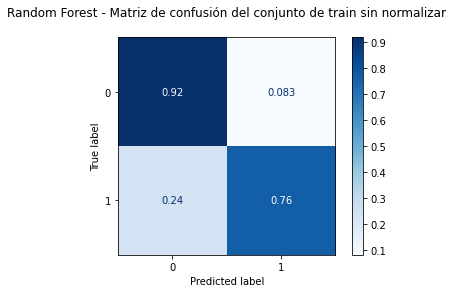

In [194]:
plt.figure()
plot_confusion_matrix(estimator= cv_ranf, X=X_train_c, y_true=y_train_c,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('Random Forest - Matriz de confusión del conjunto de train sin normalizar\n')

Text(0.5, 1.0, 'Random Forest - Matriz de confusión del conjunto de validation sin normalizar\n')

<Figure size 432x288 with 0 Axes>

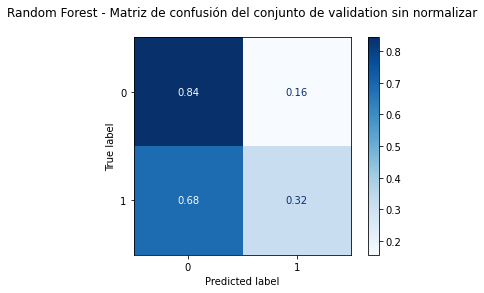

In [196]:
plt.figure()
plot_confusion_matrix(estimator= cv_ranf, X=X_val_c, y_true=y_val_c,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('Random Forest - Matriz de confusión del conjunto de validation sin normalizar\n')

### XGBoost - Default

In [197]:
from xgboost import XGBClassifier

In [198]:
xgb = XGBClassifier(random_state= 0)
xgb.fit(X_train_c, y_train_c)

c:\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:43:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [199]:
# Predict
y_train_pred_xgb = xgb.predict(X_train_c)
y_val_pred_xgb = xgb.predict(X_val_c)

In [200]:
# Evaluate train
text = "XGBClassifier - Reporte de clasificación del conjunto de train" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_train_c, y_train_pred_xgb))

XGBClassifier - Reporte de clasificación del conjunto de train
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      3370
           1       0.92      0.74      0.82      1889

    accuracy                           0.88      5259
   macro avg       0.89      0.85      0.87      5259
weighted avg       0.89      0.88      0.88      5259



In [201]:
# Evaluate val
text = "XGBClassifier - Reporte de clasificación del conjunto de validacion" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_val_c, y_val_pred_xgb))

XGBClassifier - Reporte de clasificación del conjunto de validacion
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      1517
           1       0.46      0.39      0.42       738

    accuracy                           0.65      2255
   macro avg       0.59      0.58      0.58      2255
weighted avg       0.64      0.65      0.64      2255



Text(0.5, 1.0, 'XGBClassifier - Matriz de confusión del conjunto de train sin normalizar\n')

<Figure size 432x288 with 0 Axes>

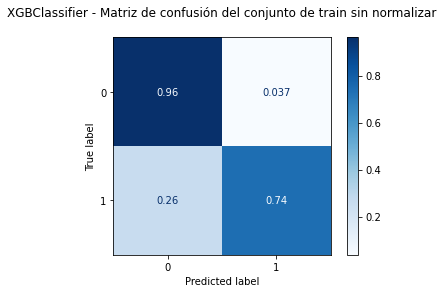

In [202]:
plt.figure()
plot_confusion_matrix(estimator= xgb, X=X_train_c, y_true=y_train_c,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('XGBClassifier - Matriz de confusión del conjunto de train sin normalizar\n')

Text(0.5, 1.0, 'XGBClassifier - Matriz de confusión del conjunto de validation sin normalizar\n')

<Figure size 432x288 with 0 Axes>

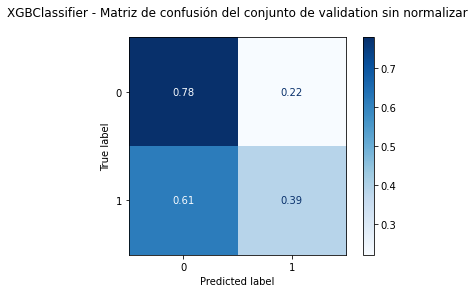

In [203]:
plt.figure()
plot_confusion_matrix(estimator= xgb, X=X_val_c, y_true=y_val_c,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('XGBClassifier - Matriz de confusión del conjunto de validation sin normalizar\n')

### XGBoost - Grid Search

In [ ]:
param_grid = {
    'alpha' : [0.01, 0.42, 0.30],
    'max_depth': [8, 16, 32],
    'n_estimators': [5, 10, 15],
    'booster':['gbtree', 'gblinear', 'dart'],
}

xgb = XGBClassifier(random_state= 0)
cv_xgb = GridSearchCV(xgb, param_grid, scoring='f1', cv=5)
cv_xgb.fit(X_train_c, y_train_c)

c:\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is depre

[20:43:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:43:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:43:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:43:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

c:\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is depre

[20:43:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:43:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:43:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is depre

[20:43:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:43:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:43:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:43:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:43:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is depre

[20:43:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:43:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:43:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:43:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:43:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:43:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is depre

[20:43:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:43:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:43:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:43:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:43:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:43:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

c:\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[20:43:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:43:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
cv_xgb.best_params_

In [ ]:
cv_xgb.best_estimator_

In [ ]:
# Predict
y_train_pred_xgb = cv_xgb.best_estimator_.predict(X_train_c)
y_val_pred_xgb = cv_xgb.best_estimator_.predict(X_val_c)

In [ ]:
# Evaluate train
text = "XGBClassifier - Reporte de clasificación del conjunto de train" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_train_c, y_train_pred_xgb))

In [ ]:
# Evaluate val
text = "XGBClassifier - Reporte de clasificación del conjunto de validacion" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_val_c, y_val_pred_xgb))

In [ ]:
plt.figure()
plot_confusion_matrix(estimator= cv_xgb, X=X_train_c, y_true=y_train_c,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('XGBClassifier - Matriz de confusión del conjunto de train sin normalizar\n')

In [ ]:
plt.figure()
plot_confusion_matrix(estimator= cv_xgb, X=X_val_c, y_true=y_val_c,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('XGBClassifier - Matriz de confusión del conjunto de validation sin normalizar\n')

## 5. Series Temporales (Optativo)
* Hacer un forecasting usando Exponential Smoothing

En el modelo de Exponential Smoothing, las predicciones son promedios pesados de observaciones pasadas, donde los pesos decaen exponencialmente cuando nos movemos al pasado:
$$
\hat{y}_{t + 1} = l_t \\
l_t = \alpha y_t + (1 - \alpha) l_{t - 1}
$$

Donde:

Asumimos que:
* $l_0$ está dado
* 0 $< \alpha <$ 1

El método se suele usar cuando los datos no tienen patrones de tendencia ni estacional claros.


In [ ]:
print(statsmodels.__version__)
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(15, 10)})

Para cargar el dataset

In [ ]:
df = pd.read_parquet("cupones_ds.parquet")

In [ ]:
df.head(5)

In [ ]:
cols = ['producto_naranja_movimiento', 'monto_compra_movimiento', 'fecha_cupon_movimiento']

In [ ]:
df[cols]

In [ ]:
sf = df[cols][df.producto_naranja_movimiento == 'PL']
sf

In [ ]:
cols = ['fecha_cupon_movimiento', 'monto_compra_movimiento']
sf = sf[cols].groupby(by=['fecha_cupon_movimiento'], dropna=True).sum()

In [ ]:
sf.reset_index(inplace=True)
sf

In [ ]:
print(sf['fecha_cupon_movimiento'].max())
print(sf['fecha_cupon_movimiento'].min())

In [ ]:
sf.set_index('fecha_cupon_movimiento', inplace=True)
sf

En series temporales se usa Series en lugar de Dataframe

In [ ]:
ss = sf['monto_compra_movimiento']
ss

In [ ]:
fig = plt.figure(figsize=(18, 6))

ax = plt.subplot(1, 1, 1)
ss.plot(color='dodgerblue')
ax.set_xlabel('Dia')
ax.set_ylabel('monto_compra_movimiento')
ax.set_title('Comportamiento monto_compra_movimiento para PL')

plt.tight_layout()
plt.show()

In [ ]:
y_test = sf.monto_compra_movimiento.loc['2021-03-19':]
y_train = sf[~sf.monto_compra_movimiento.isin(y_test)].monto_compra_movimiento


In [ ]:
print(y_test.index.max())
print(y_test.index.min())

In [ ]:
print(y_train.index.max())
print(y_train.index.min())

## Seasonal Random Walk (Seasonal Naïve)

#### Descomposicion

Una operación fundamental para entender el comportamiento de una serie de
 tiempo y poder determinar si se trata de una serie `estacionaria` o no

La **descomposición** es una técnica que trata de descomponer una serie de tiempo en su tendencia, su estacionalidad y sus factores residuales

Ejemplo de descomposición de serie de tiempo

<img 
src="https://i.imgur.com/g0PQASf.png" />


In [ ]:
res = sm.tsa.seasonal_decompose(
    sf['monto_compra_movimiento'], model='additive', freq=30
    )

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(18, 14))

ax1.set_title('Inbound fueatures')
sf.monto_compra_movimiento.plot(ax=ax1, color='red')
ax1.set_ylabel('Original')

res.trend.plot(ax=ax2)
ax2.set_ylabel('Fluctuaciones')

res.resid.plot(ax=ax3)
ax3.set_ylabel('Variaciones Irregulares')

res.seasonal.plot(ax=ax4)
ax4.set_ylabel('Variaciones Estacionales')
plt.tight_layout()
plt.show()

## Forecast

In [ ]:
model = ARIMA(
    endog=y_train, exog=None, order=(0, 0, 1), seasonal_order=(0, 1, 0, 42)
    ).fit()
    

In [ ]:
fig = plt.figure(figsize=(18, 12), dpi=100)

ax = plt.subplot(2, 1, 1)
y_train.tail(200).plot(ax=ax, label='Train Values', linestyle='-')
model.fittedvalues.tail(200).plot(
    ax=ax, label='fitted Values', marker='o', linestyle='--')
ax.set_title('monto_compra_movimiento')
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Forecast
# 95% conf se, conf
fc = model.forecast(steps=len(y_test), exog=y_test, alpha=0.05) 
#Make as pandas series
fc_in = fc.reset_index(drop=True)
fc_in.index = y_test.index

In [ ]:
fig = plt.figure(figsize=(18, 12))

ax = plt.subplot(2, 1, 1)
y_test.plot(ax=ax, label='actual Test')
fc_in.plot(ax=ax, label='forecast', marker='o', linestyle='--')
ax.set_title('Forecast vs Actuals for Inbound Features')
ax.legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
table = pd.DataFrame(
    [(sm.tools.eval_measures.rmse(y_test, fc_in), 
      (y_test - fc_in).sem())],
      columns=['RMSE','SE']
      )
table.round(3)